In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 设置
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 0.001







# GPU配置

 这里设置了设备配置，以便自动选择使用GPU（如果可用）进行硬件加速，从而提高模型训练的效率。

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据加载与预处理
  load_data 函数处理批量数据加载，包括数据预处理和增广步骤。它使用 PyTorch 的 DataLoader 来混洗和并行加载数据，优化训练过程。

In [12]:
def load_data(batch_size):
    # 数据预处理和增广
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    # 加载训练集和测试集
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader

# 绘制训练与测试曲线
plot_curves 函数旨在可视化整个训练过程中的损失和测试精度，提供模型性能和收敛模式的直观理解。

In [13]:
def plot_curves(history, title=""):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.title('Loss Trend ' + title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['test_acc'], label='Testing Accuracy')
    plt.title('Accuracy Trend ' + title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 模型评估
evaluate_model 函数通过计算给定数据集上的准确率，定量评估模型性能，为比较提供了一个清晰的度量标准。

In [14]:
def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# 卷积网络(ConvNet)架构
 此段定义了卷积网络架构 ConvNet，允许使用不同的卷积层数、通道数和激活函数实例化模型。该类设计灵活，便于实验不同的网络配置。

In [15]:
class ConvNet(nn.Module):
    def __init__(self, num_layers=2, conv_channels=[32, 64], activation_fn=F.relu):
        super(ConvNet, self).__init__()
        self.layers = nn.ModuleList()
        in_channels = 3  # CIFAR10的输入通道为3

        for i in range(num_layers):
            out_channels = conv_channels[i] if i < len(conv_channels) else conv_channels[-1]
            self.layers.append(nn.Conv2d(in_channels, out_channels, 3, padding=1))
            self.layers.append(nn.MaxPool2d(2, 2))
            if activation_fn == F.relu:
                self.layers.append(nn.ReLU())
            elif activation_fn == F.leaky_relu:
                self.layers.append(nn.LeakyReLU())
            in_channels = out_channels

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, 10)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# 实验运行
 run_experiment 函数封装了完整的训练流程——包括加载数据、定义模型、设置损失函数、优化器和学习率调度器，然后迭代进行训练和评估。最后通过绘图函数来可视化训练进度。

In [16]:
def run_experiment(batch_size, epochs, learning_rate, num_layers, conv_channels, activation_fn, title):
    trainloader, testloader = load_data(batch_size)

    model = ConvNet(num_layers=num_layers, conv_channels=conv_channels, activation_fn=activation_fn).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    history = {'train_loss': [], 'test_acc': []}

    # 训练循环
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        test_acc = evaluate_model(model, testloader)
        history['train_loss'].append(running_loss / len(trainloader))
        history['test_acc'].append(test_acc)

        print(f'Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}, Accuracy: {test_acc}%')

    plot_curves(history, title=title)

# 主执行块及实验配置
在主执行块中，定义了一系列模型配置，以测试不同的超参数和结构选择，例如层深度和激活函数。每个配置随后传递给 run_experiment 来训练模型并可视化其性能。

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.9592355886078856, Accuracy: 36.4%
Epoch 2, Loss: 1.7134508565258797, Accuracy: 38.83%
Epoch 3, Loss: 1.640858821246935, Accuracy: 42.38%
Epoch 4, Loss: 1.5800948871675964, Accuracy: 44.47%
Epoch 5, Loss: 1.5317811462885278, Accuracy: 45.06%
Epoch 6, Loss: 1.4852940999638393, Accuracy: 47.73%
Epoch 7, Loss: 1.477877779385013, Accuracy: 48.08%
Epoch 8, Loss: 1.4728603186204916, Accuracy: 47.78%
Epoch 9, Loss: 1.4666234763991801, Accuracy: 48.22%
Epoch 10, Loss: 1.462001449921552, Accuracy: 48.48%


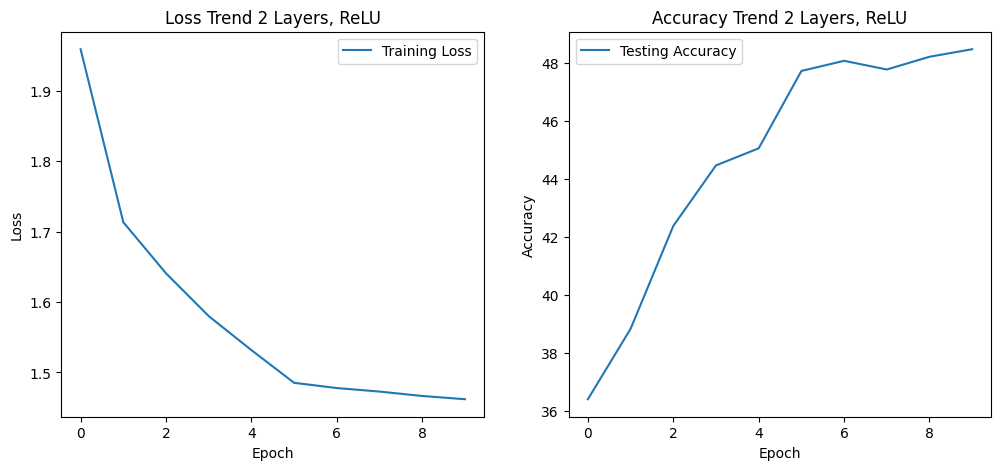

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.7440909964349263, Accuracy: 43.44%
Epoch 2, Loss: 1.4656944878570868, Accuracy: 49.87%
Epoch 3, Loss: 1.3291079665693786, Accuracy: 54.48%
Epoch 4, Loss: 1.2321014639056858, Accuracy: 57.87%
Epoch 5, Loss: 1.1605931793332405, Accuracy: 58.06%
Epoch 6, Loss: 1.07601682761746, Accuracy: 61.71%
Epoch 7, Loss: 1.0609779466143654, Accuracy: 62.12%
Epoch 8, Loss: 1.0540195991620993, Accuracy: 62.97%
Epoch 9, Loss: 1.0445422502734778, Accuracy: 62.52%
Epoch 10, Loss: 1.0392134936569293, Accuracy: 62.77%


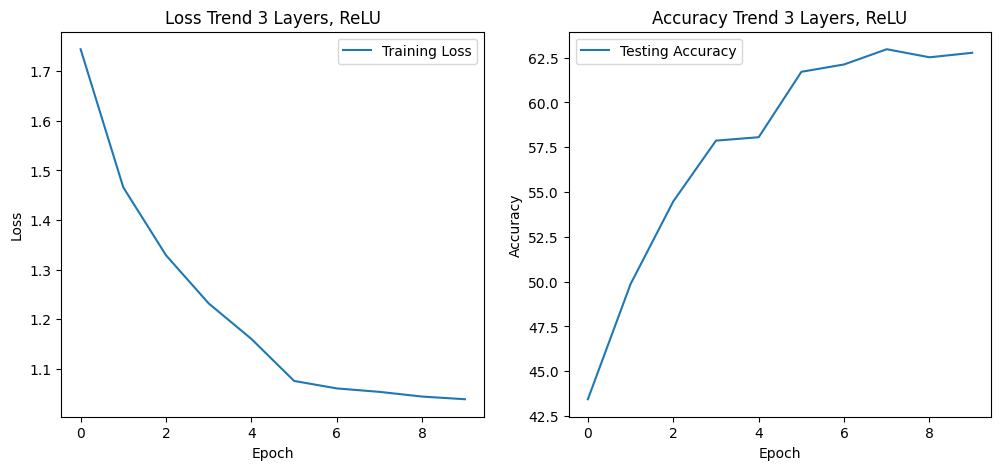

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.8509271147915773, Accuracy: 39.02%
Epoch 2, Loss: 1.6073369089599765, Accuracy: 41.93%
Epoch 3, Loss: 1.508248078548695, Accuracy: 47.18%
Epoch 4, Loss: 1.4352377738489215, Accuracy: 49.18%
Epoch 5, Loss: 1.3786380019639155, Accuracy: 50.94%
Epoch 6, Loss: 1.326563636360266, Accuracy: 53.01%
Epoch 7, Loss: 1.318327637584618, Accuracy: 53.21%
Epoch 8, Loss: 1.3139480190813695, Accuracy: 53.07%
Epoch 9, Loss: 1.3091625545335852, Accuracy: 53.67%
Epoch 10, Loss: 1.3045730956680024, Accuracy: 53.58%


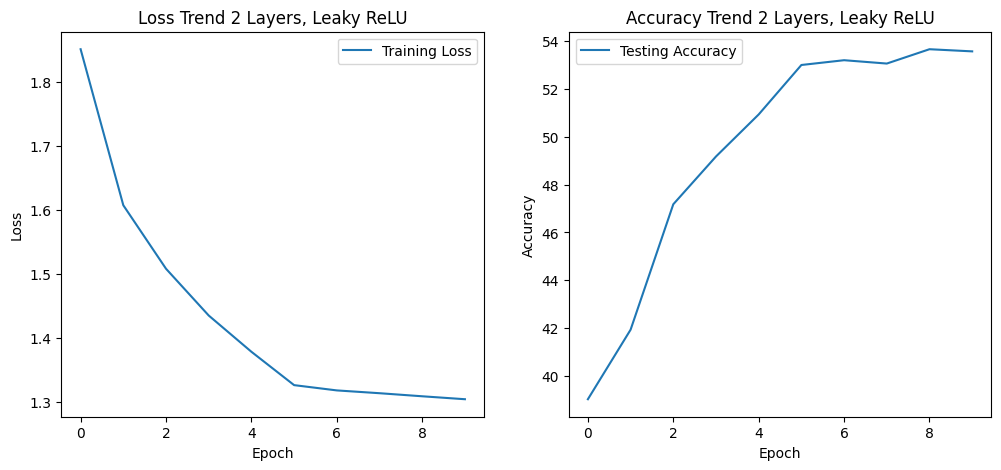

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.5905549651216668, Accuracy: 47.73%
Epoch 2, Loss: 1.2066013011176262, Accuracy: 61.29%
Epoch 3, Loss: 1.0199669302272065, Accuracy: 63.37%
Epoch 4, Loss: 0.8866329310495226, Accuracy: 70.16%
Epoch 5, Loss: 0.7947940100032045, Accuracy: 71.17%
Epoch 6, Loss: 0.6665419471995605, Accuracy: 74.57%
Epoch 7, Loss: 0.6448470391428379, Accuracy: 74.57%
Epoch 8, Loss: 0.6301630273499452, Accuracy: 74.95%
Epoch 9, Loss: 0.6198515517022604, Accuracy: 75.16%
Epoch 10, Loss: 0.6085988022482304, Accuracy: 75.12%


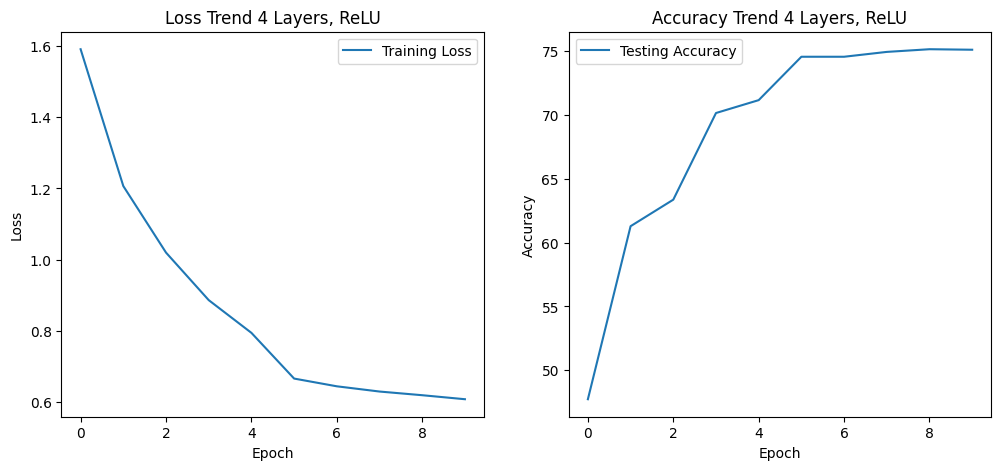

In [18]:
if __name__ == '__main__':
    configurations = [
        {'num_layers': 2, 'conv_channels': [32, 64], 'activation_fn': F.relu, 'title': "2 Layers, ReLU"},
        {'num_layers': 3, 'conv_channels': [32, 64, 128], 'activation_fn': F.relu, 'title': "3 Layers, ReLU"},
        {'num_layers': 2, 'conv_channels': [64, 128], 'activation_fn': F.leaky_relu, 'title': "2 Layers, Leaky ReLU"},
        {'num_layers': 4, 'conv_channels': [32, 64, 128, 256], 'activation_fn': F.relu, 'title': "4 Layers, ReLU"}
    ]

    for config in configurations:
        run_experiment(BATCH_SIZE, EPOCHS, LEARNING_RATE, **config)